# Ising Model Cheat Sheet

In [1]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

if 'root_dir' not in locals():
    # Navigate to examples/ directory as project root directory
    import os
    os.chdir("../")
    root_dir = os.getcwd()

# To be able to compute custom measures
import sys
sys.path.append("./python_scripts")
    
mcmc_model_dir = "IsingModelSimulation/"
mcmc_data_dir = root_dir + "/data/" + mcmc_model_dir
mcmc_results_dir = root_dir + "/results/" + mcmc_model_dir

data_dir = root_dir + "/data/" + mcmc_model_dir
results_dir = root_dir + "/results/" + mcmc_model_dir

## MCMC Results

### Expectation Values

In [2]:
from mcmctools.modes.expectation_value import load_expectation_value_results
expectation_values = load_expectation_value_results(files_dir="IsingModelSimulation")
expectation_values

Quantity,ExpVal,Error,ExpVal,Error,ExpVal,Error,ExpVal,Error
Observable,AbsMean,AbsMean,Energy,Energy,Mean,Mean,SecondMoment,SecondMoment
beta,,,,,,,,
0.100000,0.249119,0.187821,0.021949,0.036080,-0.003644,0.311972,1.0,0.0
0.200000,0.353125,0.242470,0.093870,0.087260,0.006012,0.428321,1.0,0.0
0.300000,0.522981,0.292431,0.253718,0.164978,0.014669,0.599019,1.0,0.0
0.400000,0.743681,0.273916,0.532835,0.229513,0.001769,0.792538,1.0,0.0
0.500000,0.913075,0.169752,0.873794,0.196500,0.618313,0.692989,1.0,0.0
0.600000,0.970031,0.096800,1.143300,0.143292,0.419531,0.879979,1.0,0.0
0.700000,0.988500,0.049204,1.371151,0.112708,-0.988500,0.049204,1.0,0.0


## Correlation Times

In [3]:
from pystatplottools.utils.utils import load_json
# Loaded from different simulation
correlation_times = load_json("./results/IsingModelSimulation/correlation_time_results.json")
print(correlation_times)

{'CorrelationTime': {'0.100000': 14, '0.200000': 25, '0.300000': 63, '0.400000': 184, '0.500000': 22, '0.600000': 23, '0.700000': 31}}


## Configurations as Pytorch Dataset

We show how the mcmc configurations can be stored and loaded as a .pt file.

(See also python_scripts/loading_configurations.py and python_scripts/pytorch_data_generation.py)

### Preparation

In [4]:
data_generator_args = {
    # ConfigDataGenerator Args
    "data_type": "target_param",
    # Args for ConfigurationLoader
    "path": mcmc_data_dir,
    "total_number_of_data_per_file": 20000,
    "identifier": "expectation_value",
    "running_parameter": "beta",
    "chunksize": 400  # If no chunksize is given, all data is loaded at once
}

# Prepare in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import prepare_in_memory_dataset
from mcmctools.pytorch.data_generation.datagenerationroutines import data_generator_factory

prepare_in_memory_dataset(
    root=data_dir,
    batch_size=89,
    data_generator_args=data_generator_args,
    data_generator_name="BatchConfigDataGenerator",
    data_generator_factory=data_generator_factory
)

### Generating and Loading the Dataset

In [5]:
# Load in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import load_in_memory_dataset

# The dataset is generated and stored as a .pt file in the data_dir/data directory the first time this function is called. Otherwise the .pt is loaded.
data_loader = load_in_memory_dataset(
    root=data_dir, batch_size=89, data_generator_factory=data_generator_factory, slices=None, shuffle=True,
    num_workers=0, rebuild=False
    # sample_data_generator_name="ConfigDataGenerator"  # optional: for a generation of new samples
)

# Load training data
for batch_idx, batch in enumerate(data_loader):
    data, target = batch
    # print(batch_idx, len(data))

RDKit WARNING: [21:31:35] Enabling RDKit 2019.09.1b1 jupyter extensions


### Inspection of the Dataset - Sample Visualization

In [6]:
from pystatplottools.visualization import sample_visualization

config_dim = (4, 4)  # Dimension of the data
ab = (-1, 1)  # Data is expected to be in the range (-1, 1)

# Random sample
config, label = data_loader.dataset.get_random_sample()

# Alternative
# dataset_inspector = data_loader.get_dataset_inspector()
# config, label = dataset_inspector.sampler()

batch, batch_label = data_loader.dataset.get_random_batch(108)

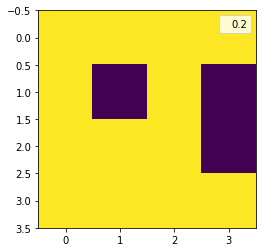

In [7]:
# Single Sample
sample_visualization.fd_im_single_sample(sample=config, label=label, config_dim=config_dim, ab=ab,
                                         fma=fma, filename="single_sample", directory=results_dir, figsize=(4, 4));

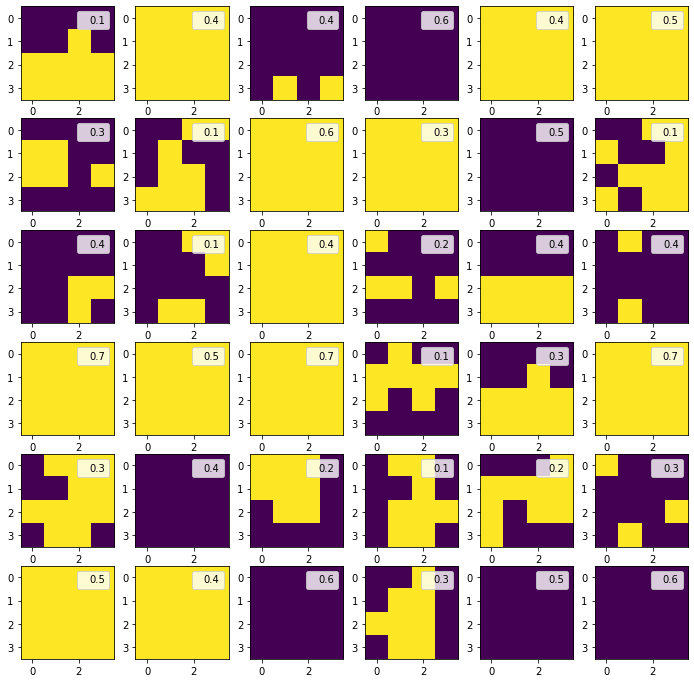

In [8]:
# Batch with labels
sample_visualization.fd_im_batch(batch, batch_labels=batch_label, num_samples=36, dim=(6, 6),
                                 config_dim=config_dim, ab=ab,
                                 fma=fma, filename="batch", directory=results_dir, width=2.3, ratio=1.0, figsize=(12, 12));

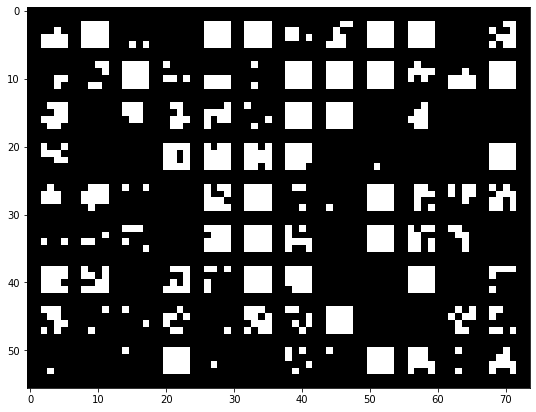

In [9]:
# Batch grid
sample_visualization.fd_im_batch_grid(batch, config_dim=config_dim, ab=ab,
                                      fma=fma, filename="batch_grid", directory=results_dir);

## Data Evaluation with the pystatplottools Library

We demonstrate possible ways to use the pystatplottools library to evaluate results of a mcmc simulation.

### Preparation

In [10]:
# Load all data
from mcmctools.loading.loading import load_data

# skipcols=[] Can be used to load only certain columns of the different files
data, filenames = load_data(files_dir=mcmc_model_dir, running_parameter="beta",
                            identifier="expectation_value")  # , skipcols=["Config"])
from mcmctools.utils.json import load_configs
sim_params, execution_params, running_parameter = load_configs(
    files_dir="IsingModelSimulation", mode="expectation_value", sim_base_dir="./")

data

quantity            AbsMean SecondMoment   Mean Beta Config                 \
elem                                                      0    1    2    3   
beta     sample_num                                                          
0.100000 0            0.250          1.0 -0.250  0.1   -1.0  1.0 -1.0 -1.0   
         1            0.125          1.0 -0.125  0.1   -1.0  1.0 -1.0 -1.0   
         2            0.125          1.0 -0.125  0.1   -1.0  1.0 -1.0 -1.0   
         3            0.000          1.0  0.000  0.1   -1.0  1.0 -1.0 -1.0   
         4            0.125          1.0 -0.125  0.1   -1.0  1.0 -1.0 -1.0   
...                     ...          ...    ...  ...    ...  ...  ...  ...   
0.700000 19995        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   
         19996        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   
         19997        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   
         19998        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   
         19999        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   

quantity                                                                    \
elem                   4    5    6    7    8    9   10   11   12   13   14   
beta     sample_num                                                          
0.100000 0           1.0  1.0  1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0  1.0 -1.0   
         1           1.0  1.0  1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0  1.0  1.0   
         2           1.0  1.0  1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0  1.0  1.0   
         3           1.0  1.0  1.0 -1.0 -1.0  1.0  1.0 -1.0 -1.0  1.0  1.0   
         4          -1.0  1.0  1.0 -1.0 -1.0  1.0  1.0 -1.0 -1.0  1.0  1.0   
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
0.700000 19995      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
         19996      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
         19997      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
         19998      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
         19999      -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   

quantity                  
elem                  15  
beta     sample_num       
0.100000 0          -1.0  
         1          -1.0  
         2          -1.0  
         3          -1.0  
         4          -1.0  
...                  ...  
0.700000 19995      -1.0  
         19996      -1.0  
         19997      -1.0  
         19998      -1.0  
         19999      -1.0  

[140000 rows x 20 columns]

### Transform to Balanced Dataset

A trick is applied to obtain a mean value for the magnetization that is approximately zero for all temperatures
without an external field - this trick should of course not be applied if the external field is finite.

In [11]:
mean_values = data.groupby("beta")["Mean"].apply(lambda x: x.mean())
percentages = (1 + mean_values) / 2.0

for beta in data.index.unique(level=0):
    random_index = None
    num_to_be_changed_rows = int(len(data) / len(data.index.unique(level=0)) * (percentages - 0.5).loc[beta])
    if num_to_be_changed_rows < 0:
        random_index = (data.loc[beta]["Mean"] < 0).sample(abs(num_to_be_changed_rows)).index
    elif num_to_be_changed_rows > 0:
        random_index = (data.loc[beta]["Mean"] > 0).sample(abs(num_to_be_changed_rows)).index
    if random_index is not None:
        data.loc[(beta, random_index), ("Config", slice(None))] = data.loc[
            (beta, random_index), ("Config", slice(None))].apply(lambda x: -1.0 * x)
    data.Mean = data.Config.values.mean(axis=1)

### Compute the Energy of the Ising model from the samples

In [12]:
from mcmctools.modes.expectation_value import compute_measures_over_config
new_measures, data = compute_measures_over_config(data=data, measures=["Energy"], sim_params=sim_params)
data

quantity            AbsMean SecondMoment   Mean Beta Config                 \
elem                                                      0    1    2    3   
beta     sample_num                                                          
0.100000 0            0.250          1.0 -0.250  0.1   -1.0  1.0 -1.0 -1.0   
         1            0.125          1.0  0.125  0.1    1.0 -1.0  1.0  1.0   
         2            0.125          1.0 -0.125  0.1   -1.0  1.0 -1.0 -1.0   
         3            0.000          1.0  0.000  0.1   -1.0  1.0 -1.0 -1.0   
         4            0.125          1.0 -0.125  0.1   -1.0  1.0 -1.0 -1.0   
...                     ...          ...    ...  ...    ...  ...  ...  ...   
0.700000 19995        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   
         19996        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   
         19997        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   
         19998        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   
         19999        1.000          1.0 -1.000  0.7   -1.0 -1.0 -1.0 -1.0   

quantity                       ...                                          \
elem                   4    5  ...    7    8    9   10   11   12   13   14   
beta     sample_num            ...                                           
0.100000 0           1.0  1.0  ... -1.0 -1.0 -1.0  1.0 -1.0 -1.0  1.0 -1.0   
         1          -1.0 -1.0  ...  1.0  1.0  1.0 -1.0  1.0  1.0 -1.0 -1.0   
         2           1.0  1.0  ... -1.0 -1.0 -1.0  1.0 -1.0 -1.0  1.0  1.0   
         3           1.0  1.0  ... -1.0 -1.0  1.0  1.0 -1.0 -1.0  1.0  1.0   
         4          -1.0  1.0  ... -1.0 -1.0  1.0  1.0 -1.0 -1.0  1.0  1.0   
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
0.700000 19995      -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
         19996      -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
         19997      -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
         19998      -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   
         19999      -1.0 -1.0  ... -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0   

quantity                 Energy  
elem                  15         
beta     sample_num              
0.100000 0          -1.0  0.025  
         1           1.0  0.025  
         2          -1.0  0.025  
         3          -1.0  0.050  
         4          -1.0  0.075  
...                  ...    ...  
0.700000 19995      -1.0  1.400  
         19996      -1.0  1.400  
         19997      -1.0  1.400  
         19998      -1.0  1.400  
         19999      -1.0  1.400  

[140000 rows x 21 columns]

### Alternativ Computation of the Expectation Values

#### General Statistics

In [13]:
from pystatplottools.expectation_values.expectation_value import ExpectationValue

ep = ExpectationValue(data=data)

# Computes for the given columns the respective expectation values - The expectation values are computed seperately for each inverse temperature 'beta'
ep.compute_expectation_value(columns=["Mean", "AbsMean", "SecondMoment"],
                             exp_values=["mean", "max", "min", "secondmoment", "fourthmoment"])

expectation_values = ep.expectation_values
if "Config" in data.columns:
    expectation_values = expectation_values.droplevel(level=1, axis=1)
expectation_values

Mean                                       AbsMean              \
              mean  max  min secondmoment fourthmoment      mean  max    min   
beta                                                                           
0.100000 -0.003606  1.0 -1.0     0.097335     0.025737  0.249119  1.0  0.000   
0.200000  0.005500  1.0 -1.0     0.183486     0.077386  0.353125  1.0  0.000   
0.300000  0.013794  1.0 -1.0     0.359021     0.225907  0.522981  1.0  0.000   
0.400000  0.001931  1.0 -1.0     0.628088     0.508291  0.743681  1.0  0.000   
0.500000  0.241375  1.0 -1.0     0.862520     0.797446  0.913075  1.0  0.000   
0.600000  0.248656  1.0 -1.0     0.950330     0.921817  0.970031  1.0  0.000   
0.700000 -0.011650  1.0 -1.0     0.979553     0.966327  0.988500  1.0  0.125   

                                   SecondMoment                         \
         secondmoment fourthmoment         mean  max  min secondmoment   
beta                                                                     
0.100000     0.097335     0.025737          1.0  1.0  1.0          1.0   
0.200000     0.183486     0.077386          1.0  1.0  1.0          1.0   
0.300000     0.359021     0.225907          1.0  1.0  1.0          1.0   
0.400000     0.628088     0.508291          1.0  1.0  1.0          1.0   
0.500000     0.862520     0.797446          1.0  1.0  1.0          1.0   
0.600000     0.950330     0.921817          1.0  1.0  1.0          1.0   
0.700000     0.979553     0.966327          1.0  1.0  1.0          1.0   

                       
         fourthmoment  
beta                   
0.100000          1.0  
0.200000          1.0  
0.300000          1.0  
0.400000          1.0  
0.500000          1.0  
0.600000          1.0  
0.700000          1.0

#### Visualization

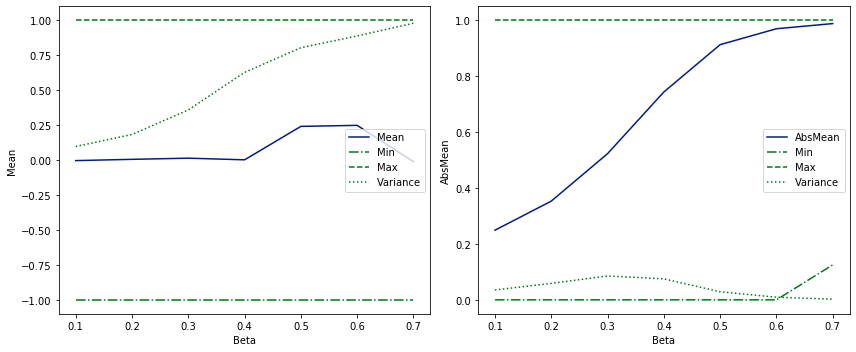

In [14]:
fig, axes = fma.newfig(1.4, ratio=0.5, ncols=2, figsize=(12, 5))

betas = expectation_values.index.values.astype(np.float32)

axes[0].plot(betas, expectation_values["Mean"]["mean"], label="Mean")
axes[0].plot(betas, expectation_values["Mean"]["min"], color="C{}".format(1), ls="-.", label="Min")
axes[0].plot(betas, expectation_values["Mean"]["max"], color="C{}".format(1), ls="--", label="Max")
axes[0].plot(betas,
             expectation_values["Mean"]["secondmoment"] - expectation_values["Mean"]["mean"].apply(
                 lambda x: np.power(x, 2.0)
             ),
             color="C{}".format(1), ls=":", label="Variance")

axes[0].legend()
axes[0].set_xlabel("Beta")
axes[0].set_ylabel("Mean")

axes[1].plot(betas, expectation_values["AbsMean"]["mean"], label="AbsMean")
axes[1].plot(betas, expectation_values["AbsMean"]["min"], color="C{}".format(1), ls="-.", label="Min")
axes[1].plot(betas, expectation_values["AbsMean"]["max"], color="C{}".format(1), ls="--", label="Max")
axes[1].plot(betas,
             expectation_values["AbsMean"]["secondmoment"] - expectation_values["AbsMean"]["mean"].apply(
                 lambda x: np.power(x, 2.0)
             ), color="C{}".format(1), ls=":", label="Variance")

axes[1].legend()
axes[1].set_xlabel("Beta")
axes[1].set_ylabel("AbsMean")

plt.tight_layout()

fma.savefig(results_dir, "expectation_values")

#### Specific Heat and Binder Cumulant

In [15]:
# Add necessary expectation values to exisiting expectation values
ep.compute_expectation_value(columns=["Mean"], exp_values=["secondmoment", "fourthmoment"])
ep.compute_expectation_value(columns=["Energy"], exp_values=["var"])

expectation_values = ep.expectation_values
if "Config" in data.columns:
    expectation_values = expectation_values.droplevel(level=1, axis=1)

n_sites = len(data.iloc[0]["Config"])

binder_cumulant = 1.0 - expectation_values["Mean"]["fourthmoment"] / (
        3.0 * expectation_values["Mean"]["secondmoment"].pow(2.0))

specific_heat = np.power(expectation_values.index.values.astype(np.float), 2.0) / n_sites * \
                expectation_values["Energy"]["var"]
observables = pd.concat([binder_cumulant, specific_heat], axis=1, keys=["BinderCumulant", "SpecificHeat"])
observables

,BinderCumulant,SpecificHeat
beta,,
0.100000,0.094479,8.136164e-07
0.200000,0.233811,1.903576e-05
0.300000,0.415791,1.531004e-04
0.400000,0.570513,5.267600e-04
0.500000,0.642693,6.033155e-04
0.600000,0.659769,4.619844e-04
0.700000,0.664303,3.890325e-04


#### Visualization

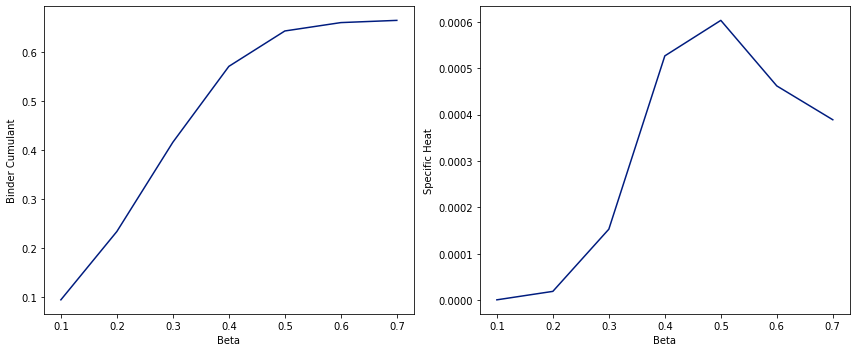

In [16]:
fig, axes = fma.newfig(1.4, ratio=0.5, ncols=2, figsize=(12, 5))

betas = observables.index.values.astype(np.float32)

axes[0].plot(betas, observables["BinderCumulant"])
axes[0].set_xlabel("Beta")
axes[0].set_ylabel("Binder Cumulant")

axes[1].plot(betas, observables["SpecificHeat"])
axes[1].set_xlabel("Beta")
axes[1].set_ylabel("Specific Heat")

plt.tight_layout()

fma.savefig(results_dir, "observables")

### Histograms for the Different Inverse Temperatures

In [17]:
from pystatplottools.distributions.marginal_distribution import MarginalDistribution

histograms = MarginalDistribution(data=data)

range_min, range_max = histograms.extract_min_max_range_values(columns=["Mean", "AbsMean", "Energy"])

histograms.compute(
    axes_indices=["Mean", "AbsMean", "Energy"],
    range_min=range_min,
    range_max=range_max,
    nbins=8,
    statistic='probability',
    bin_scales='linear'
)

linearized_histograms = histograms.linearize(
    order_by_bin=True,
    bin_alignment="center"
)
linearized_histograms

bin_num_and_dfs      bin  0.100000  0.200000  0.300000  0.400000  0.500000  \
statistics idx                                                               
Mean       0    -0.87500   0.00395   0.01975   0.09765   0.27515   0.31380   
           1    -0.62500   0.03140   0.08145   0.13075   0.11245   0.03525   
           2    -0.37500   0.13160   0.15295   0.12405   0.05205   0.00900   
           3    -0.12500   0.25885   0.18985   0.10625   0.04150   0.00950   
           4     0.12500   0.29675   0.20365   0.11155   0.04170   0.00975   
           5     0.37500   0.19705   0.17440   0.12710   0.05430   0.00940   
           6     0.62500   0.07150   0.12155   0.12970   0.09050   0.02730   
           7     0.87500   0.00890   0.05640   0.17295   0.33235   0.58600   
AbsMean    0     0.06250   0.15180   0.10385   0.05410   0.01990   0.00540   
           1     0.18750   0.28890   0.19600   0.11065   0.04200   0.00975   
           2     0.31250   0.23290   0.18695   0.11535   0.04540   0.00870   
           3     0.43750   0.16225   0.16480   0.12475   0.05400   0.00900   
           4     0.56250   0.09695   0.13810   0.12395   0.06205   0.01315   
           5     0.68750   0.04540   0.10610   0.13965   0.10000   0.02870   
           6     0.81250   0.01640   0.06110   0.13095   0.14545   0.07470   
           7     0.93750   0.00540   0.04310   0.20060   0.53120   0.85060   
Energy     0    -0.19375   0.00055   0.01160   0.00235   0.00235   0.00015   
           1     0.01875   0.98865   0.68255   0.18385   0.04650   0.00065   
           2     0.23125   0.01080   0.29635   0.54520   0.19725   0.01980   
           3     0.44375   0.00000   0.00950   0.18430   0.22270   0.07185   
           4     0.65625   0.00000   0.00000   0.08430   0.21585   0.25560   
           5     0.86875   0.00000   0.00000   0.00000   0.31535   0.00000   
           6     1.08125   0.00000   0.00000   0.00000   0.00000   0.65195   
           7     1.29375   0.00000   0.00000   0.00000   0.00000   0.00000   

bin_num_and_dfs  0.600000  0.700000  
statistics idx                       
Mean       0      0.35765   0.49855  
           1      0.00960   0.00605  
           2      0.00190   0.00095  
           3      0.00265   0.00020  
           4      0.00305   0.00000  
           5      0.00160   0.00050  
           6      0.00440   0.00170  
           7      0.61915   0.49205  
AbsMean    0      0.00255   0.00000  
           1      0.00185   0.00010  
           2      0.00210   0.00015  
           3      0.00200   0.00080  
           4      0.00170   0.00105  
           5      0.00485   0.00250  
           6      0.02220   0.00955  
           7      0.96275   0.98585  
Energy     0      0.00000   0.00000  
           1      0.00020   0.00020  
           2      0.00305   0.00025  
           3      0.00655   0.00200  
           4      0.02745   0.00450  
           5      0.11805   0.00720  
           6      0.00000   0.05560  
           7      0.84470   0.93025

#### Visualization

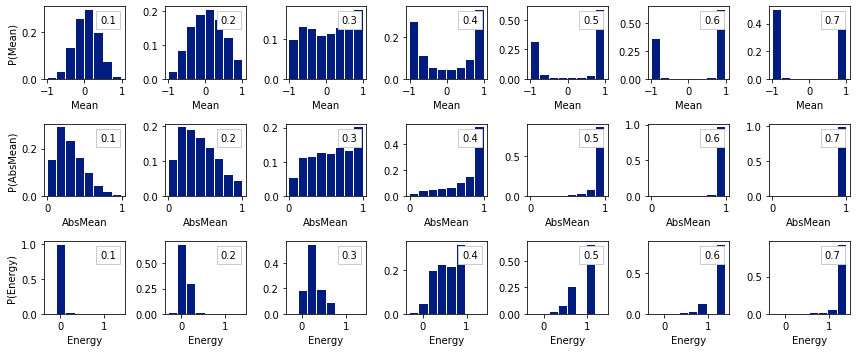

In [18]:
from pystatplottools.utils.bins_and_alignment import revert_align_bins

betas = data.index.unique(0)

fig, axes = fma.newfig(1.8, nrows=3, ncols=7, ratio=0.5, figsize=(12, 5))
for i, beta in enumerate(betas):
    for j, observable in enumerate(["Mean", "AbsMean", "Energy"]):
        binedges = revert_align_bins(
            data_range=linearized_histograms.loc[observable]["bin"].values,
            bin_alignment="center"
        )
        width = 0.9 * (binedges[1:] - binedges[:-1])

        axes[j][i].bar(
            x=linearized_histograms.loc[observable]["bin"].values,
            height=linearized_histograms.loc[observable][beta].values,
            width=width
        )
        axes[j][i].set_xlabel(observable)
        from pystatplottools.visualization.utils import add_fancy_legend_box

        add_fancy_legend_box(ax=axes[j][i], name=float(beta))

for j, observable in enumerate(["Mean", "AbsMean", "Energy"]):
    axes[j][0].set_ylabel("P(" + observable + ")")

plt.tight_layout()

fma.savefig(results_dir, "histograms")

### Joint Distribution and Contour Plot - Probability of Mean vs. Temperature With Logarithmic Scale

In [19]:
from pystatplottools.distributions.joint_distribution import JointDistribution

from pystatplottools.utils.utils import drop_index_level

joint_distribution = JointDistribution(data=drop_index_level(data))

range_min, range_max = joint_distribution.extract_min_max_range_values(["Beta", "Mean"])

joint_distribution.compute(
    axes_indices=["Beta", "Mean"],
    range_min=[0.05, range_min[1]],
    range_max=[0.75, range_max[1]],
    nbins=[7, 10],
    statistic="probability"
)

# The histograms can be accessed via: joint_distribution.distribution or linearized.

# Transforms joint_distribution into a linear list of mid boundaries for the different bins
# and the respective statistics for the values
linearized_joint_distribution = joint_distribution.linearize(
    output_statistics_name="prob",
    dataframes_as_columns=False,
    bin_alignment="center"
)
linearized_joint_distribution

axes_and_statistics  Beta  Mean      prob
dfs idx                                  
df  0                 0.1  -0.9  0.000564
    1                 0.1  -0.7  0.004486
    2                 0.1  -0.5  0.006914
    3                 0.1  -0.3  0.028300
    4                 0.1  -0.1  0.020564
...                   ...   ...       ...
    65                0.7   0.1  0.000000
    66                0.7   0.3  0.000071
    67                0.7   0.5  0.000064
    68                0.7   0.7  0.000857
    69                0.7   0.9  0.069614

[70 rows x 3 columns]

#### Visualization

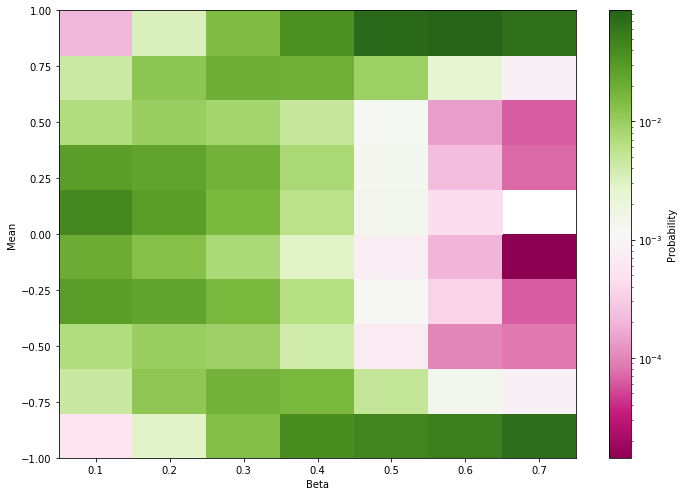

In [20]:
# Contour plot
fig, ax = fma.newfig(1.4, figsize=(10, 7))

from pystatplottools.plotting.contour2D import Contour2D

contour2D = Contour2D(
    ax=ax,
    data=linearized_joint_distribution.loc["df"],
    x="Beta",  # possibility to rescale x and y axis or perform other operation for x axis
    # like computing a mass difference
    y="Mean",
    z_index="prob"
)

norm, levs = contour2D.get_log_norm_and_levs(lev_min=0.00001, lev_max=1, lev_num=40)
contour2D.set_ax_labels(x_label="Beta", y_label="Mean")
cf = contour2D.pcolormesh(
    norm=norm,
    levs=levs,
    cmap="PiYG"
)
contour2D.add_colorbar(fig=fig, cf=cf, z_label="Probability")

plt.tight_layout()
fma.savefig(results_dir, "mean_vs_beta")